In [1]:
%matplotlib inline

from modsim import *

In [2]:
# S = % SUSCEPTIBLE, I = % INFECTED, R = % RECOVERED

In [3]:
def make_system(S=89, I=1, N=0, D=0, contact_rate = .11, safe_rate = .02, death_rate=.006, t_end = 200):
    
    pop = State(S = S, I = I, N = N, D=D)  #creates initial population
    pop /= sum(pop)             #converts population to percentages

    t0 = 0

    return System(init=pop, t0=t0, t_end=t_end,
                  contact_rate = contact_rate, death_rate = death_rate, safe_rate = safe_rate)

In [4]:
def update(state, system):
    
    unpack(system)
    
    s, i, n , d = state       
    
    infected = contact_rate * i * s
    non_infectious = safe_rate*i
    dead = death_rate * i
    
    s -= infected
    i += infected - non_infectious - dead
    n += non_infectious
    d += dead
    
    return State(S=s, I=i, N=n, D=d)

In [5]:
# def run_simulation(system, update_func):
#     unpack(system)
#     state = pop
#     for t in linrange(t0, t_end):
#         state = update_func(state, system)
#     return state

In [6]:
def run_simulation(system, update_func):
    
    
    frame = DataFrame(columns = system.init.index)
    frame.loc[system.t0] = system.init
    
    for i in linrange(system.t0, system.t_end):
        frame.loc[i+1] = update_func(frame.loc[i], system)
    
    system.results = frame
    

In [7]:
def plot_results(S, I, N, D):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(N, ':', color='green', label='Non-Infectious')
    plot(D, '-', color='black', label='Dead')
    decorate(xlabel='Time (Years)',
             ylabel='Fraction of population')

In [8]:
test_system = make_system(S=318000, I=550, N=550, D=0, contact_rate = .11, safe_rate = .02, death_rate=.006, t_end =75)
test_system.init

,value
S,0.996553
I,0.001724
N,0.001724
D,0.000000


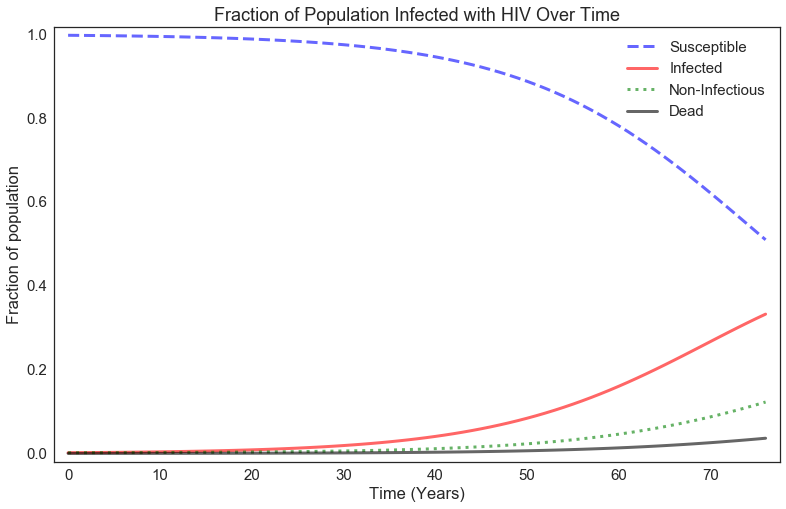

In [40]:
run_simulation(test_system, update)
frame= test_system.results
plot_results(frame.S, frame.I, frame.N, frame.D)
decorate(title='Fraction of Population Infected with HIV Over Time')
#plt.rcParams["figure.figsize"] = [13,8]

In [12]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

In [13]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=40000, K=.35, B=0.0001)

In [14]:
spending = linspace(0, 100000, 21)
spending

array([      0.,    5000.,   10000.,   15000.,   20000.,   25000.,
         30000.,   35000.,   40000.,   45000.,   50000.,   55000.,
         60000.,   65000.,   70000.,   75000.,   80000.,   85000.,
         90000.,   95000.,  100000.])

Saving figure to file chap05-fig04.pdf


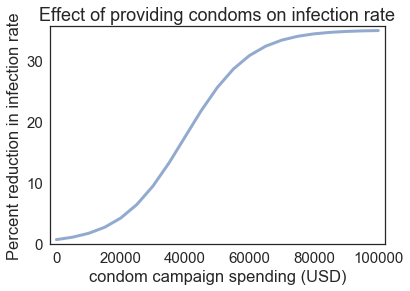

In [15]:
percent_reduction = compute_factor(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='condom campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of providing condoms on infection rate',
         legend=False)

savefig('chap05-fig04.pdf')

In [16]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end]

def add_condoms(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.contact_rate *= (1-factor)
    
def sweep_condoms(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    for spending in spending_array:
        #system = test_system = make_system(S=318000, I=550, N=550, D=0, contact_rate = .11, safe_rate = 0, death_rate=.006, t_end =75)
        add_condoms(system, spending)
        run_simulation(system, update)
        sweep[spending] = calc_total_infected(system)
    return sweep    

In [17]:
infected_sweep = sweep_condoms(spending)

plot(infected_sweep)

decorate(xlabel='Condom campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of condoms on total infections',
         legend=False)


NameError: name 'system' is not defined

In [18]:
def linear(x, slope=1):
    value = slope*x
    return value

def compute_factor_ARV(spending):
     return linear(spending,slope=.000015)

In [19]:
# def compute_factor_ARV(spending):
#     """Reduction factor as a function of spending.
    
#     spending: dollars from 0 to 1200
    
#     returns: fractional reduction in beta
#     """
#     return logistic(spending, M=40000, K=.2, B=0.0001)


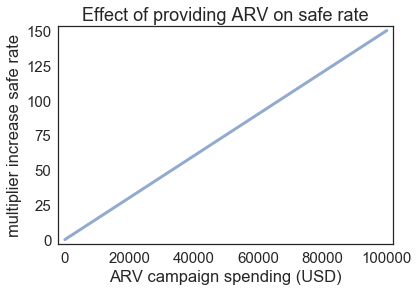

In [20]:
percent_reduction = compute_factor_ARV(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='ARV campaign spending (USD)',
         ylabel='multiplier increase safe rate',
         title='Effect of providing ARV on safe rate',
         legend=False)


In [21]:
def add_ARV(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor_ARV(spending)
    system.safe_rate *= factor
    
def sweep_ARV(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    for spending in spending_array:
        system = test_system = make_system(S=318000, I=550, N=550, D=0, contact_rate = .11, safe_rate = .02, death_rate=.006, t_end =75)
        add_ARV(system, spending)
        run_simulation(system, update)
        sweep[spending] = calc_total_infected(system)
    return sweep    

Saving figure to file chap05-fig05.pdf


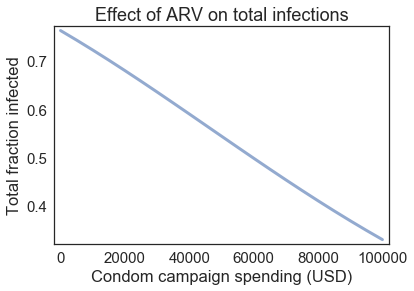

In [22]:
infected_sweep_ARV = sweep_ARV(spending)

plot(infected_sweep_ARV)

decorate(xlabel='Condom campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of ARV on total infections',
         legend=False)

savefig('chap05-fig05.pdf')

In [23]:
population = 318000
budget = 100000
price_per_dose = 11
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses)
max_doses

9090

In [24]:
# def sweep_doses(dose_array):
#     """Runs simulations with different doses and campaign spending.
    
#     dose_array: range of values for number of vaccinations
    
#     return: Sweep object with total number of infections 
#     """
#     sweep = SweepSeries()
#     for doses in dose_array:
#         fraction = doses / population
#         spending = budget - doses * price_per_dose
        
#         system = make_system(S=318000, I=550, N=550, D=0, contact_rate = .11, safe_rate = .02, death_rate=.006, t_end =75)
#         add_condoms(system, fraction)
#         add_ARV(system, spending)
        
#         run_simulation(system, update)
#         sweep[doses] = calc_total_infected(system)

#     return sweep

In [25]:
#infected_sweep = sweep_doses(dose_array)
# plot(infected_sweep)

# decorate(xlabel='Doses of vaccine',
#          ylabel='Total fraction infected',
#          title='Total infections vs. doses',
#          legend=False)

# savefig('chap05-fig06.pdf')

In [101]:
spending_array= linspace(0, 100000, 21)

def sweep_spending(system,spending):
    sweep = SweepSeries()
    for spending in spending_array:
        system = make_system(S=318000, I=550, N=550, D=0, contact_rate = .11, safe_rate = .02, death_rate=.006, t_end =75)
        #print('1')
        #print(system)
        add_ARV(system, 100000-spending)
        #print('2')
        #print(system)
        add_condoms(system, spending)
        #print('3')
        #print(system)
        run_simulation(system, update)
        sweep[spending] = calc_total_infected(system)
    return sweep

Saving figure to file chap05-fig06.pdf


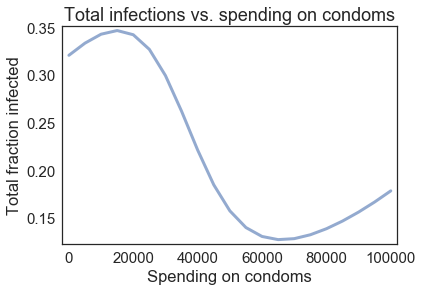

In [31]:
spending_array= linspace(0, 1, 50)

def sweep_spending(system,spending):
    sweep = SweepSeries()
    for spending in spending_array:
        system = make_system(S=318000, I=550, N=550, D=0, contact_rate = .11, safe_rate = .02, death_rate=.006, t_end =75)
        #print('1')
        #print(system)
        add_ARV(system, (1-spending)*100000)
        #print('2')
        #print(system)
        add_condoms(system, spending*100000)
        #print('3')
        #print(system)
        run_simulation(system, update)
        sweep[spending] = calc_total_infected(system)
    return sweep

Saving figure to file chap05-fig06.pdf


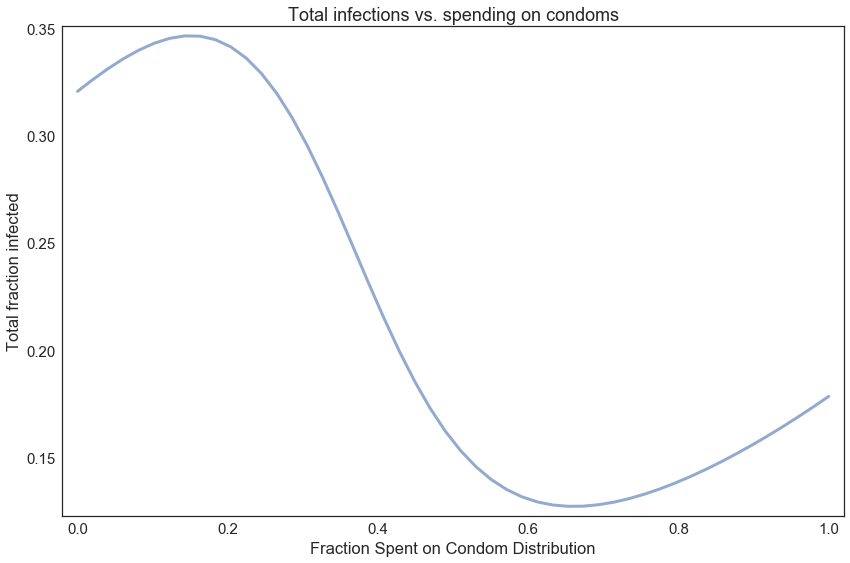

In [36]:
test_system = make_system(S=318000, I=550, N=550, D=0, contact_rate = .11, safe_rate = .02, death_rate=.006, t_end =75)
infected_sweep = sweep_spending(test_system,spending_array)
plot(infected_sweep)

decorate(xlabel='Fraction Spent on Condom Distribution',
         ylabel='Total fraction infected',
         title='Total infections vs. spending on condoms',
         legend=False)
plt.rcParams["figure.figsize"] = [13,8]

savefig('chap05-fig06.pdf')